In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from IPython import display

from utils import squeeze, get_spectrogram, plot_spectrogram, make_spec_ds, update_counts

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

data_dir = "./data/"

2023-12-19 11:33:34.336372: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 11:33:34.925834: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 11:33:34.926245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 11:33:35.034025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 11:33:35.294080: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 11:33:35.306708: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store') & (commands != 'LICENSE') & \
                    (commands != 'validation_list.txt') & (commands != 'testing_list.txt')]
print('Commands:', commands)

Commands: ['tree' 'bed' 'one' 'four' 'go' 'off' '_background_noise_' 'right' 'six'
 'happy' 'sheila' 'five' 'down' 'cat' 'three' 'no' 'left' 'two' 'bird'
 'on' 'marvin' 'zero' 'nine' 'dog' 'stop' 'house' 'seven' 'up' 'eight'
 'wow' 'yes']


Padaliname turimą duomenų rinkinį į apmokymo ir validavimo imtis.

In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Using 12945 files for validation.

label names: ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


Matome, kad turime 31 klases, kurių klasifikacijos žymos išsaugotos label_names kintamajame. Pašaliname paskutinę ašį, kadangi duomenų rinkinys turi tik vieną garso kanalą, ir padaliname validacijos rinkinį į testavimo ir validavimo imtis.

In [5]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [6]:
train_counts = {label: 0 for label in label_names}
val_counts = {label: 0 for label in label_names}
test_counts = {label: 0 for label in label_names}

update_counts(train_ds, train_counts, label_names)
update_counts(val_ds, val_counts, label_names)
update_counts(test_ds, test_counts, label_names)

print("Training Counts:")
for label, count in train_counts.items():
    print(f"{label}: {count}")

print("\nValidation Counts:")
for label, count in val_counts.items():
    print(f"{label}: {count}")

print("\Testing Counts:")
for label, count in test_counts.items():
    print(f"{label}: {count}")

Training Counts:
_background_noise_: 6
bed: 1379
bird: 1399
cat: 1361
dog: 1411
down: 1875
eight: 1881
five: 1876
four: 1892
go: 1882
happy: 1402
house: 1391
left: 1908
marvin: 1377
nine: 1886
no: 1922
off: 1880
on: 1928
one: 1879
right: 1933
seven: 1900
sheila: 1376
six: 1900
stop: 1901
three: 1886
tree: 1376
two: 1899
up: 1891
wow: 1393
yes: 1911
zero: 1881

Validation Counts:
_background_noise_: 0
bed: 164
bird: 162
cat: 198
dog: 172
down: 260
eight: 236
five: 229
four: 235
go: 241
happy: 176
house: 192
left: 209
marvin: 174
nine: 225
no: 233
off: 235
on: 237
one: 232
right: 225
seven: 236
sheila: 188
six: 235
stop: 255
three: 234
tree: 190
two: 225
up: 254
wow: 159
yes: 225
zero: 228
\Testing Counts:
_background_noise_: 0
bed: 170
bird: 170
cat: 174
dog: 163
down: 224
eight: 235
five: 252
four: 245
go: 249
happy: 164
house: 167
left: 236
marvin: 195
nine: 253
no: 220
off: 242
on: 202
one: 259
right: 209
seven: 241
sheila: 170
six: 234
stop: 224
three: 236
tree: 167
two: 249
up: 230

In [7]:
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


In [8]:
example_labels

<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([12, 24,  2,  2, 14, 20, 15, 19, 11, 24, 19,  6,  1, 19,  8, 11, 26,
       24, 15, 20,  1, 27, 17, 15,  8, 12, 24, 12, 18,  6, 16,  9, 25, 29,
        7, 28, 16,  5,  7, 19, 30, 12,  6, 27, 29, 26, 24, 12, 12, 13,  9,
       26, 13, 30, 22, 28, 17, 14,  7, 19, 15,  9, 17, 18], dtype=int32)>

Paimame kelias klases išsamesnei analizei.

In [9]:
analysis_labels = [14, 7, 22, 6]
label_names[analysis_labels]

array(['nine', 'five', 'six', 'eight'], dtype='<U18')

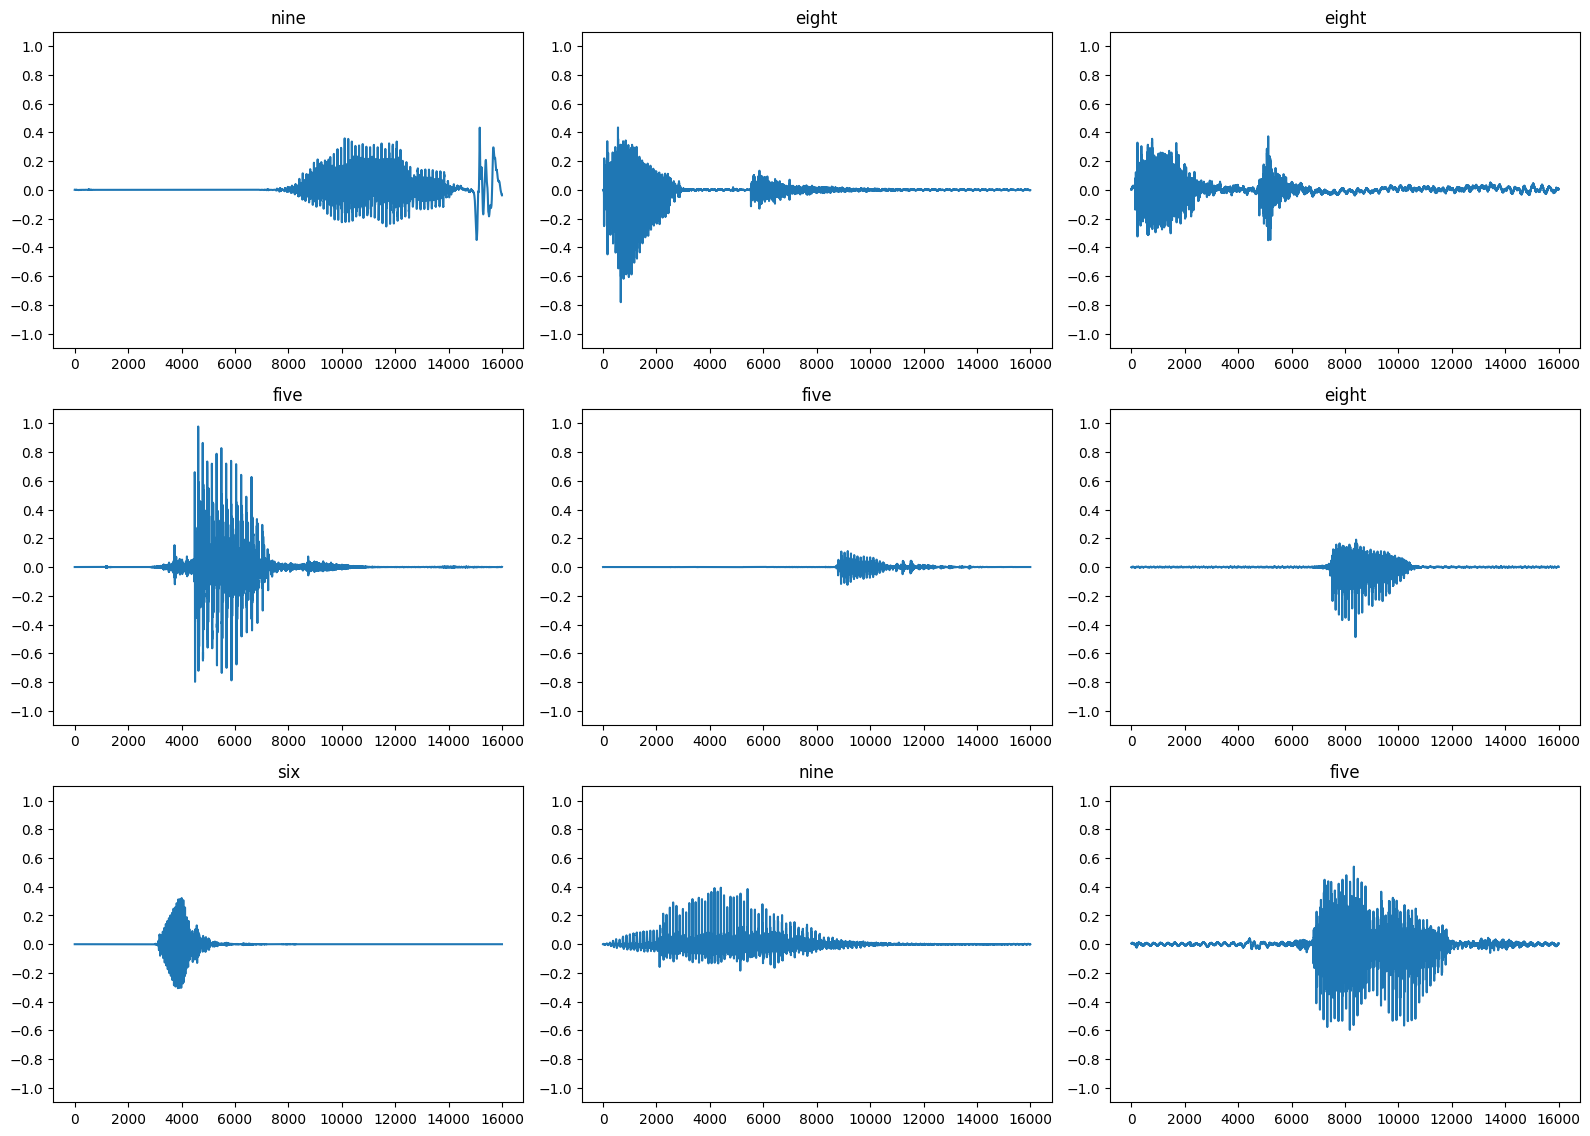

In [10]:
plt.figure(figsize=(16, 15))
plot_count = 0

for i in range(len(example_labels)):
    label = example_labels[i]
    if label in analysis_labels:
        plot_count += 1
        plt.subplot(4, 3, plot_count)
        audio_signal = example_audio[i]
        plt.plot(audio_signal)
        plt.title(label_names[label])
        plt.yticks(np.arange(-1.2, 1.2, 0.2))
        plt.ylim([-1.1, 1.1])

        if plot_count == 4*3:
            break

plt.tight_layout()


Žiūrint į "eight" ar "nine" bangų formas nepasakyčiau, jog jos atitinka tas pačias klases. Tęsiame analizę.

In [12]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: three
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: bird
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [13]:
np.random.seed(42)
choice = np.random.randint(0, len(example_labels))
choice

38

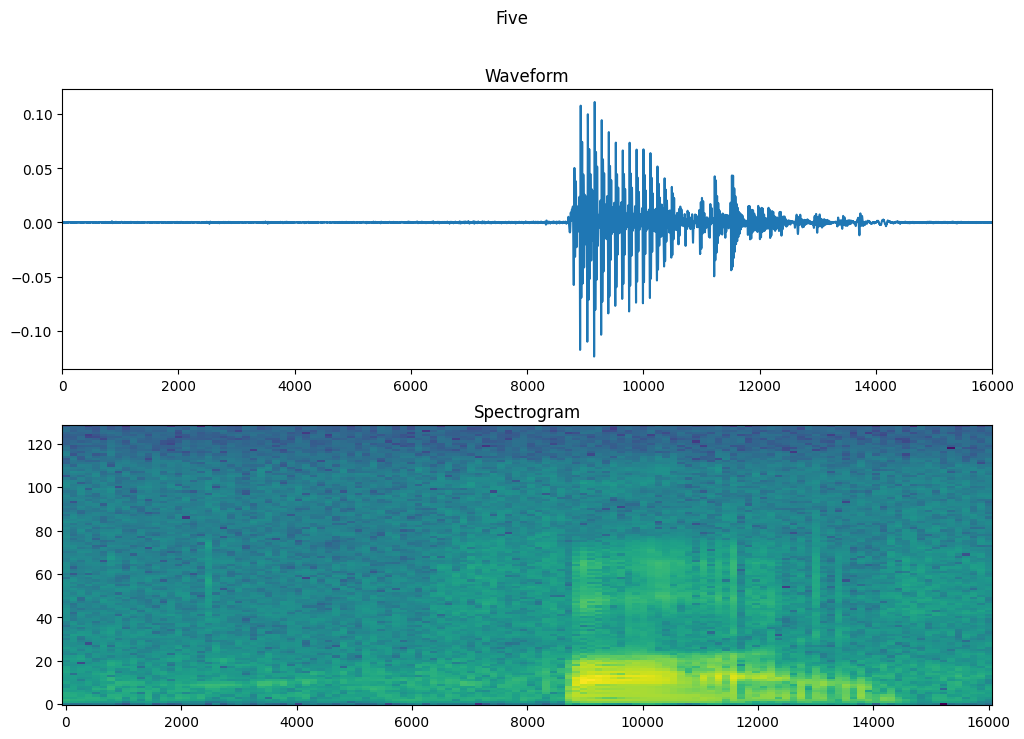

In [14]:
label = label_names[example_labels[choice]]
waveform = example_audio[choice]
spectrogram = get_spectrogram(waveform)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [15]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

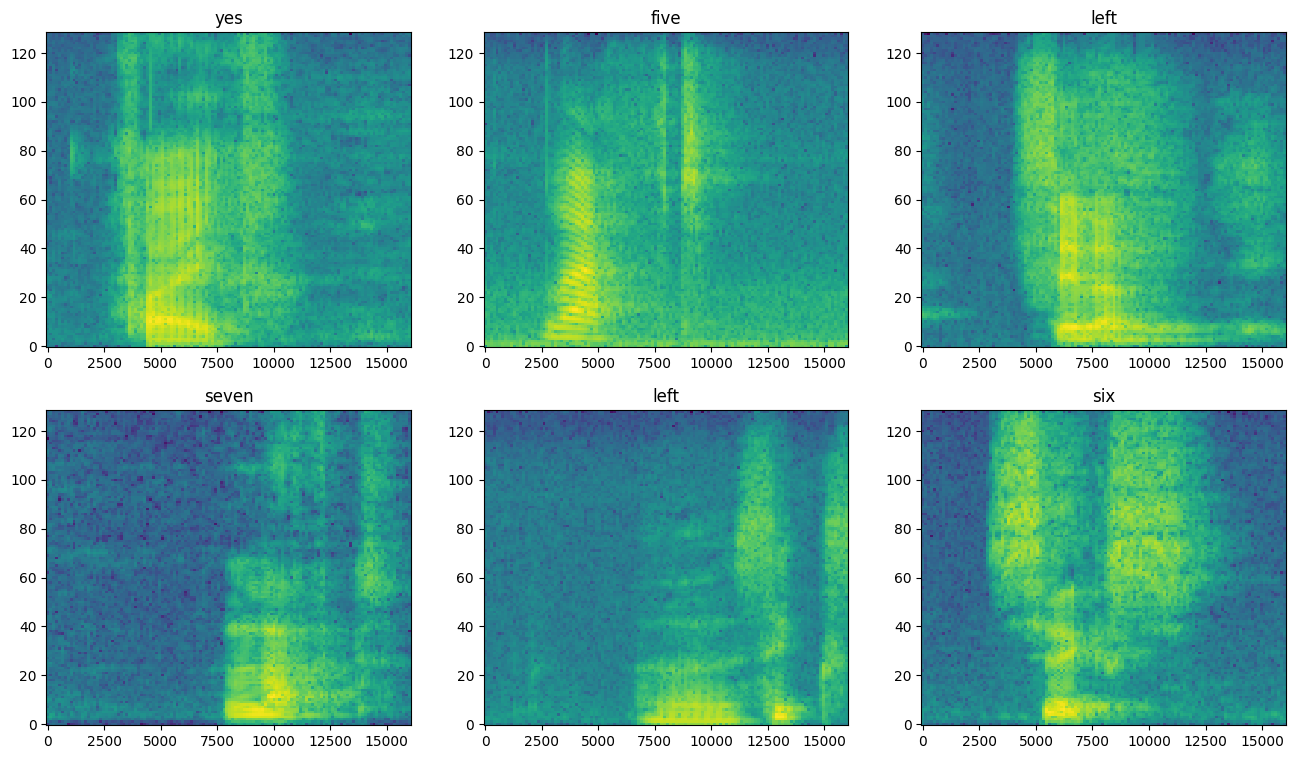

In [28]:
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i+1].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()